In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config as cfg
import seaborn as sns
import ds_functions as ds

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier

from data import hf_data, hf_data_raw, t_data, t_data_raw, get_hf_data, get_t_data
from dtree import dtree, dtree_graph

In [2]:

def KFold(X, y, nfolds):
    skf = StratifiedKFold(n_splits=nfolds)
    
    opts=()
    accuracy = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
        max_depths = [2, 5, 10, 15, 20, 25]
        criteria = ['entropy', 'gini']
        
        for k in range(len(criteria)):
            f = criteria[k]
            for d in max_depths:
                for imp in min_impurity_decrease:
                    tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
                    tree.fit(X_train, y_train)
                    prd_trn = tree.predict(X_train)
                    prd_tst = tree.predict(X_test)

                    curr_accuracy = metrics.accuracy_score(y_test, prd_tst)

                    if curr_accuracy > accuracy:
                        opts = (y_train, prd_trn, y_test, prd_tst, X_train, X_test)
                        accuracy = curr_accuracy

    return opts

# Heart Failure Dataset

## Missing Values Imputation

There are no missing values :)

In [3]:
mv = {str(var): hf_data_raw[var].isna().sum() for var in hf_data_raw if hf_data_raw[var].isna().sum() > 0}
print(len(mv))

0


## Outliers (Un)Imputation

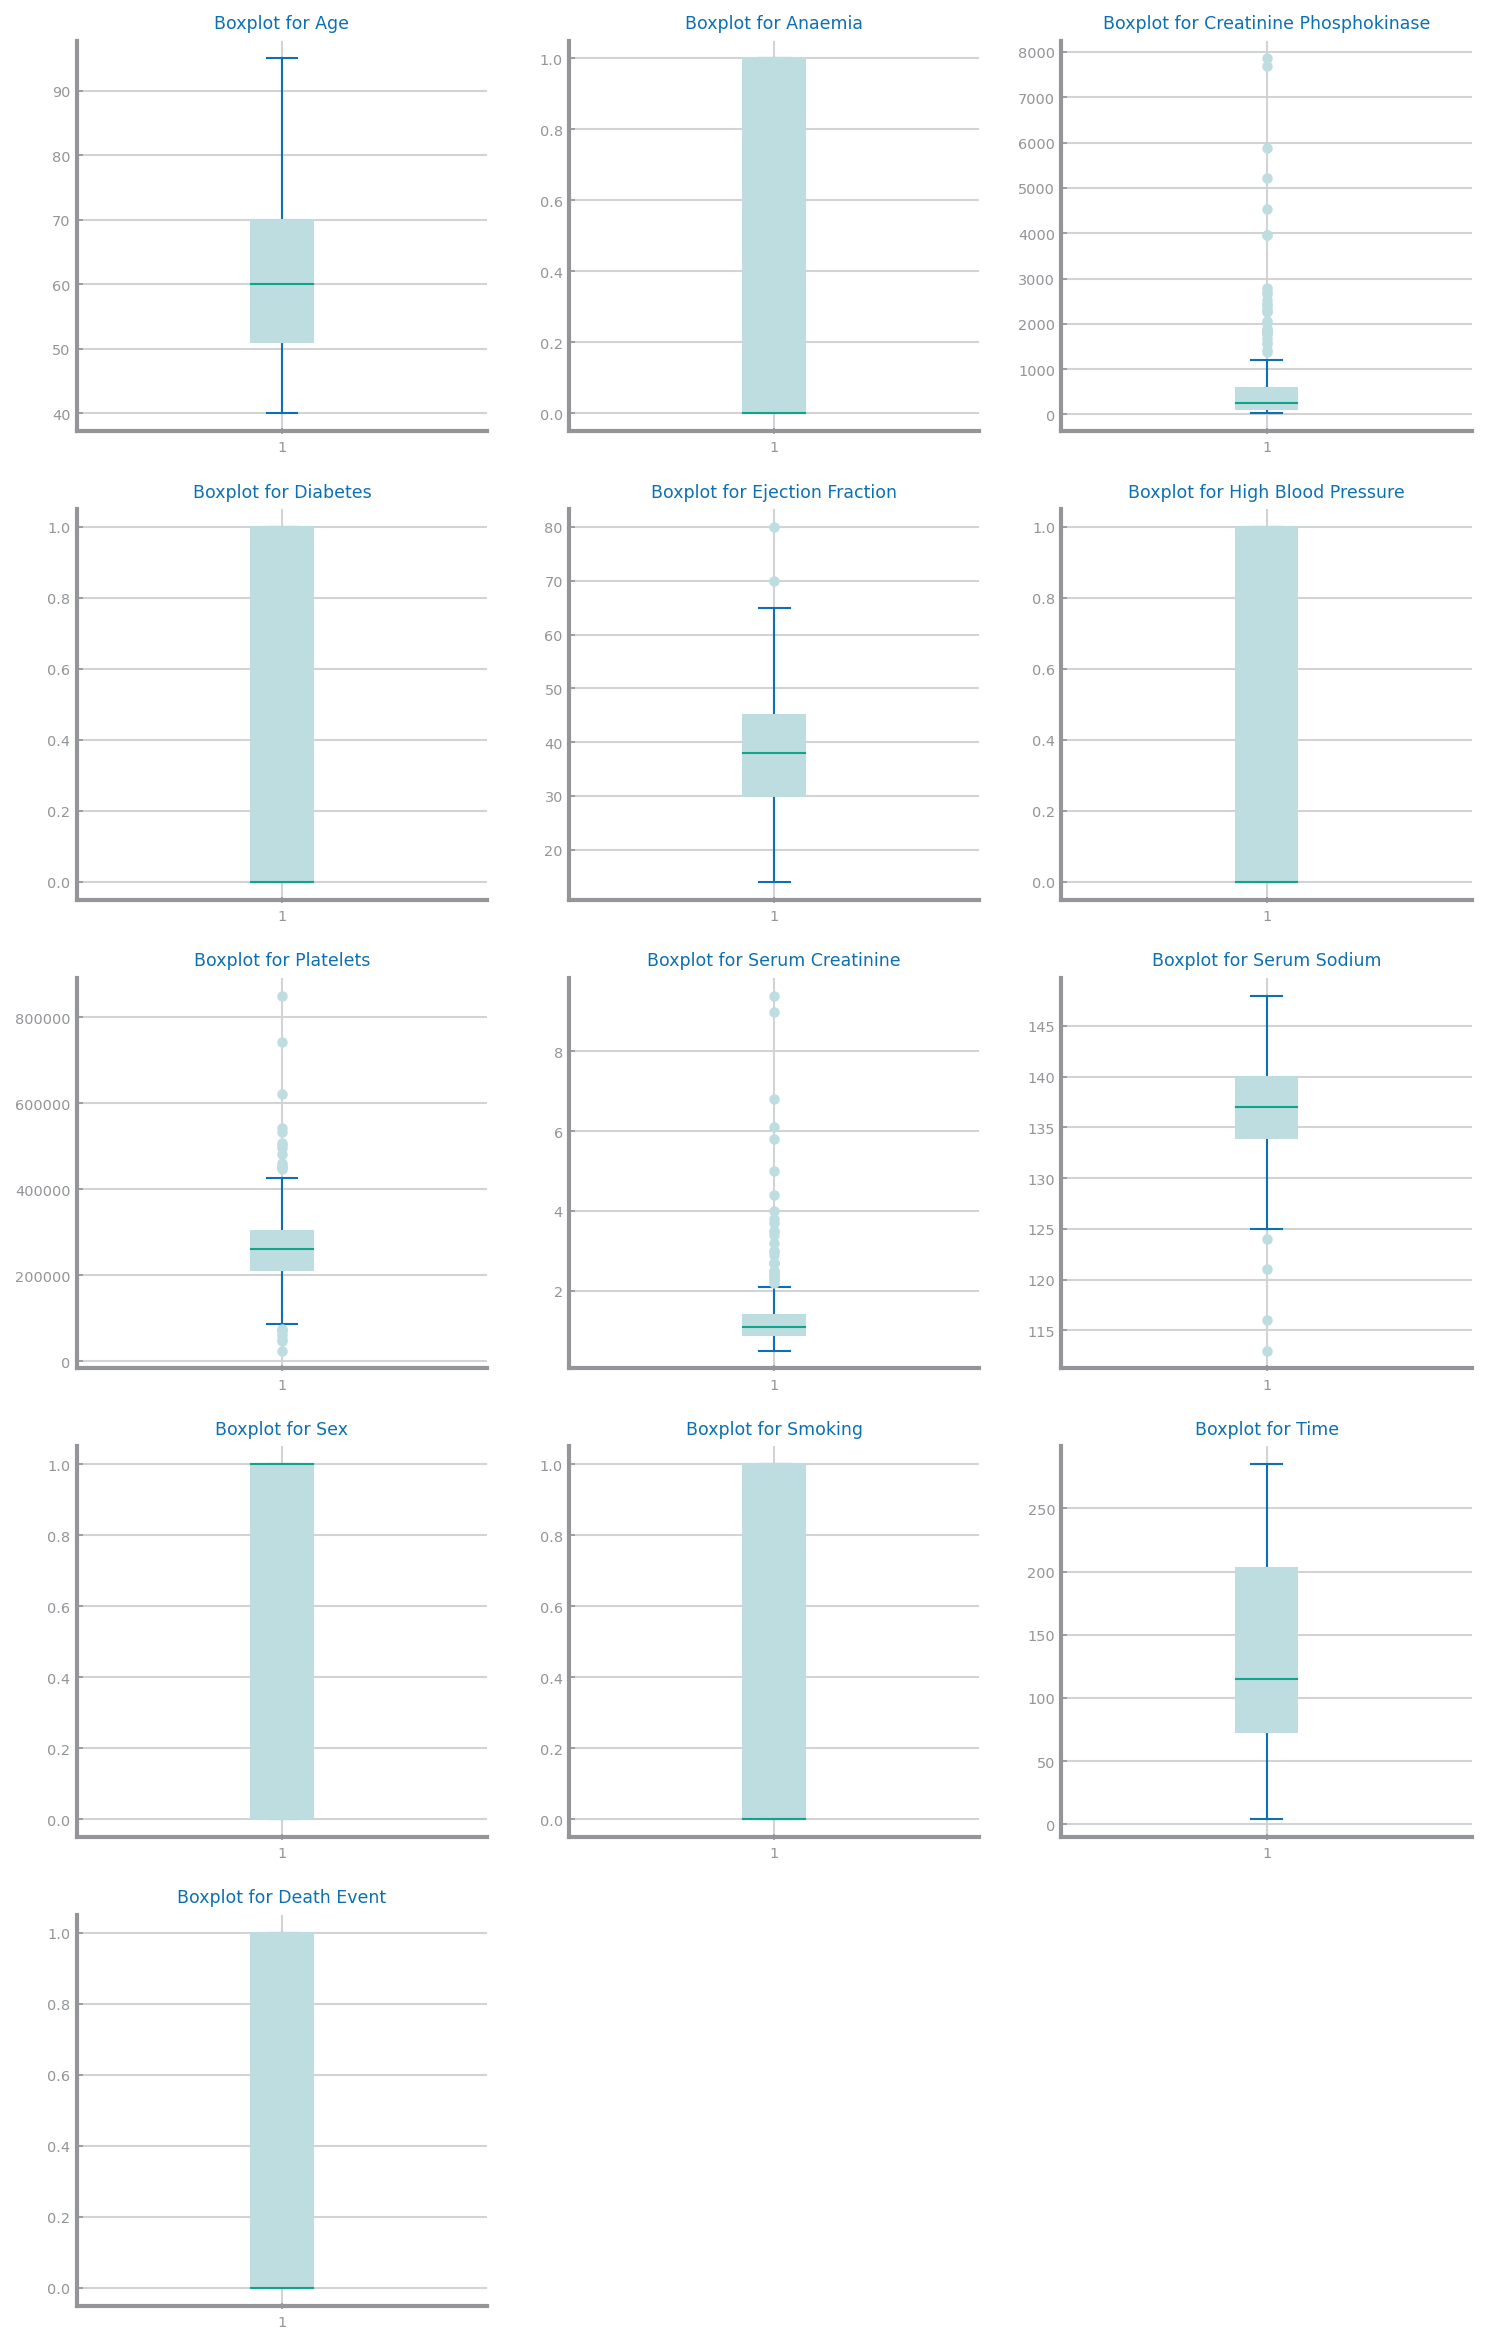

In [4]:
numeric_vars = hf_data_raw.select_dtypes(include=['float64','int64']).columns
rows, cols = ds.choose_grid(len(numeric_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(numeric_vars)):
    new_var_name = numeric_vars[n].replace("_", " ").title()
    axs[i, j].set_title(f'Boxplot for {new_var_name}')
    axs[i, j].boxplot(hf_data_raw[numeric_vars[n]].dropna().values, whis=1.5)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)

while n <= len(numeric_vars):
    axs[i, j].axis('off')
    n = n + 1
    i, j = (i + 1, 0) if n % cols == 0 else (i, j + 1)

plt.show()

In [5]:
hf_df_wo = hf_data_raw.copy()

# creatinine_phosphokinase, outliers above 3000
hf_df_wo = hf_df_wo[hf_df_wo["creatinine_phosphokinase"] <= 3000]

# serum_creatinine, outliers above 4
hf_df_wo = hf_df_wo[hf_df_wo["serum_creatinine"] <= 4]

# platelets, outliers above 600000
hf_df_wo = hf_df_wo[hf_df_wo["platelets"] <= 600000]

len(hf_df_wo)

283

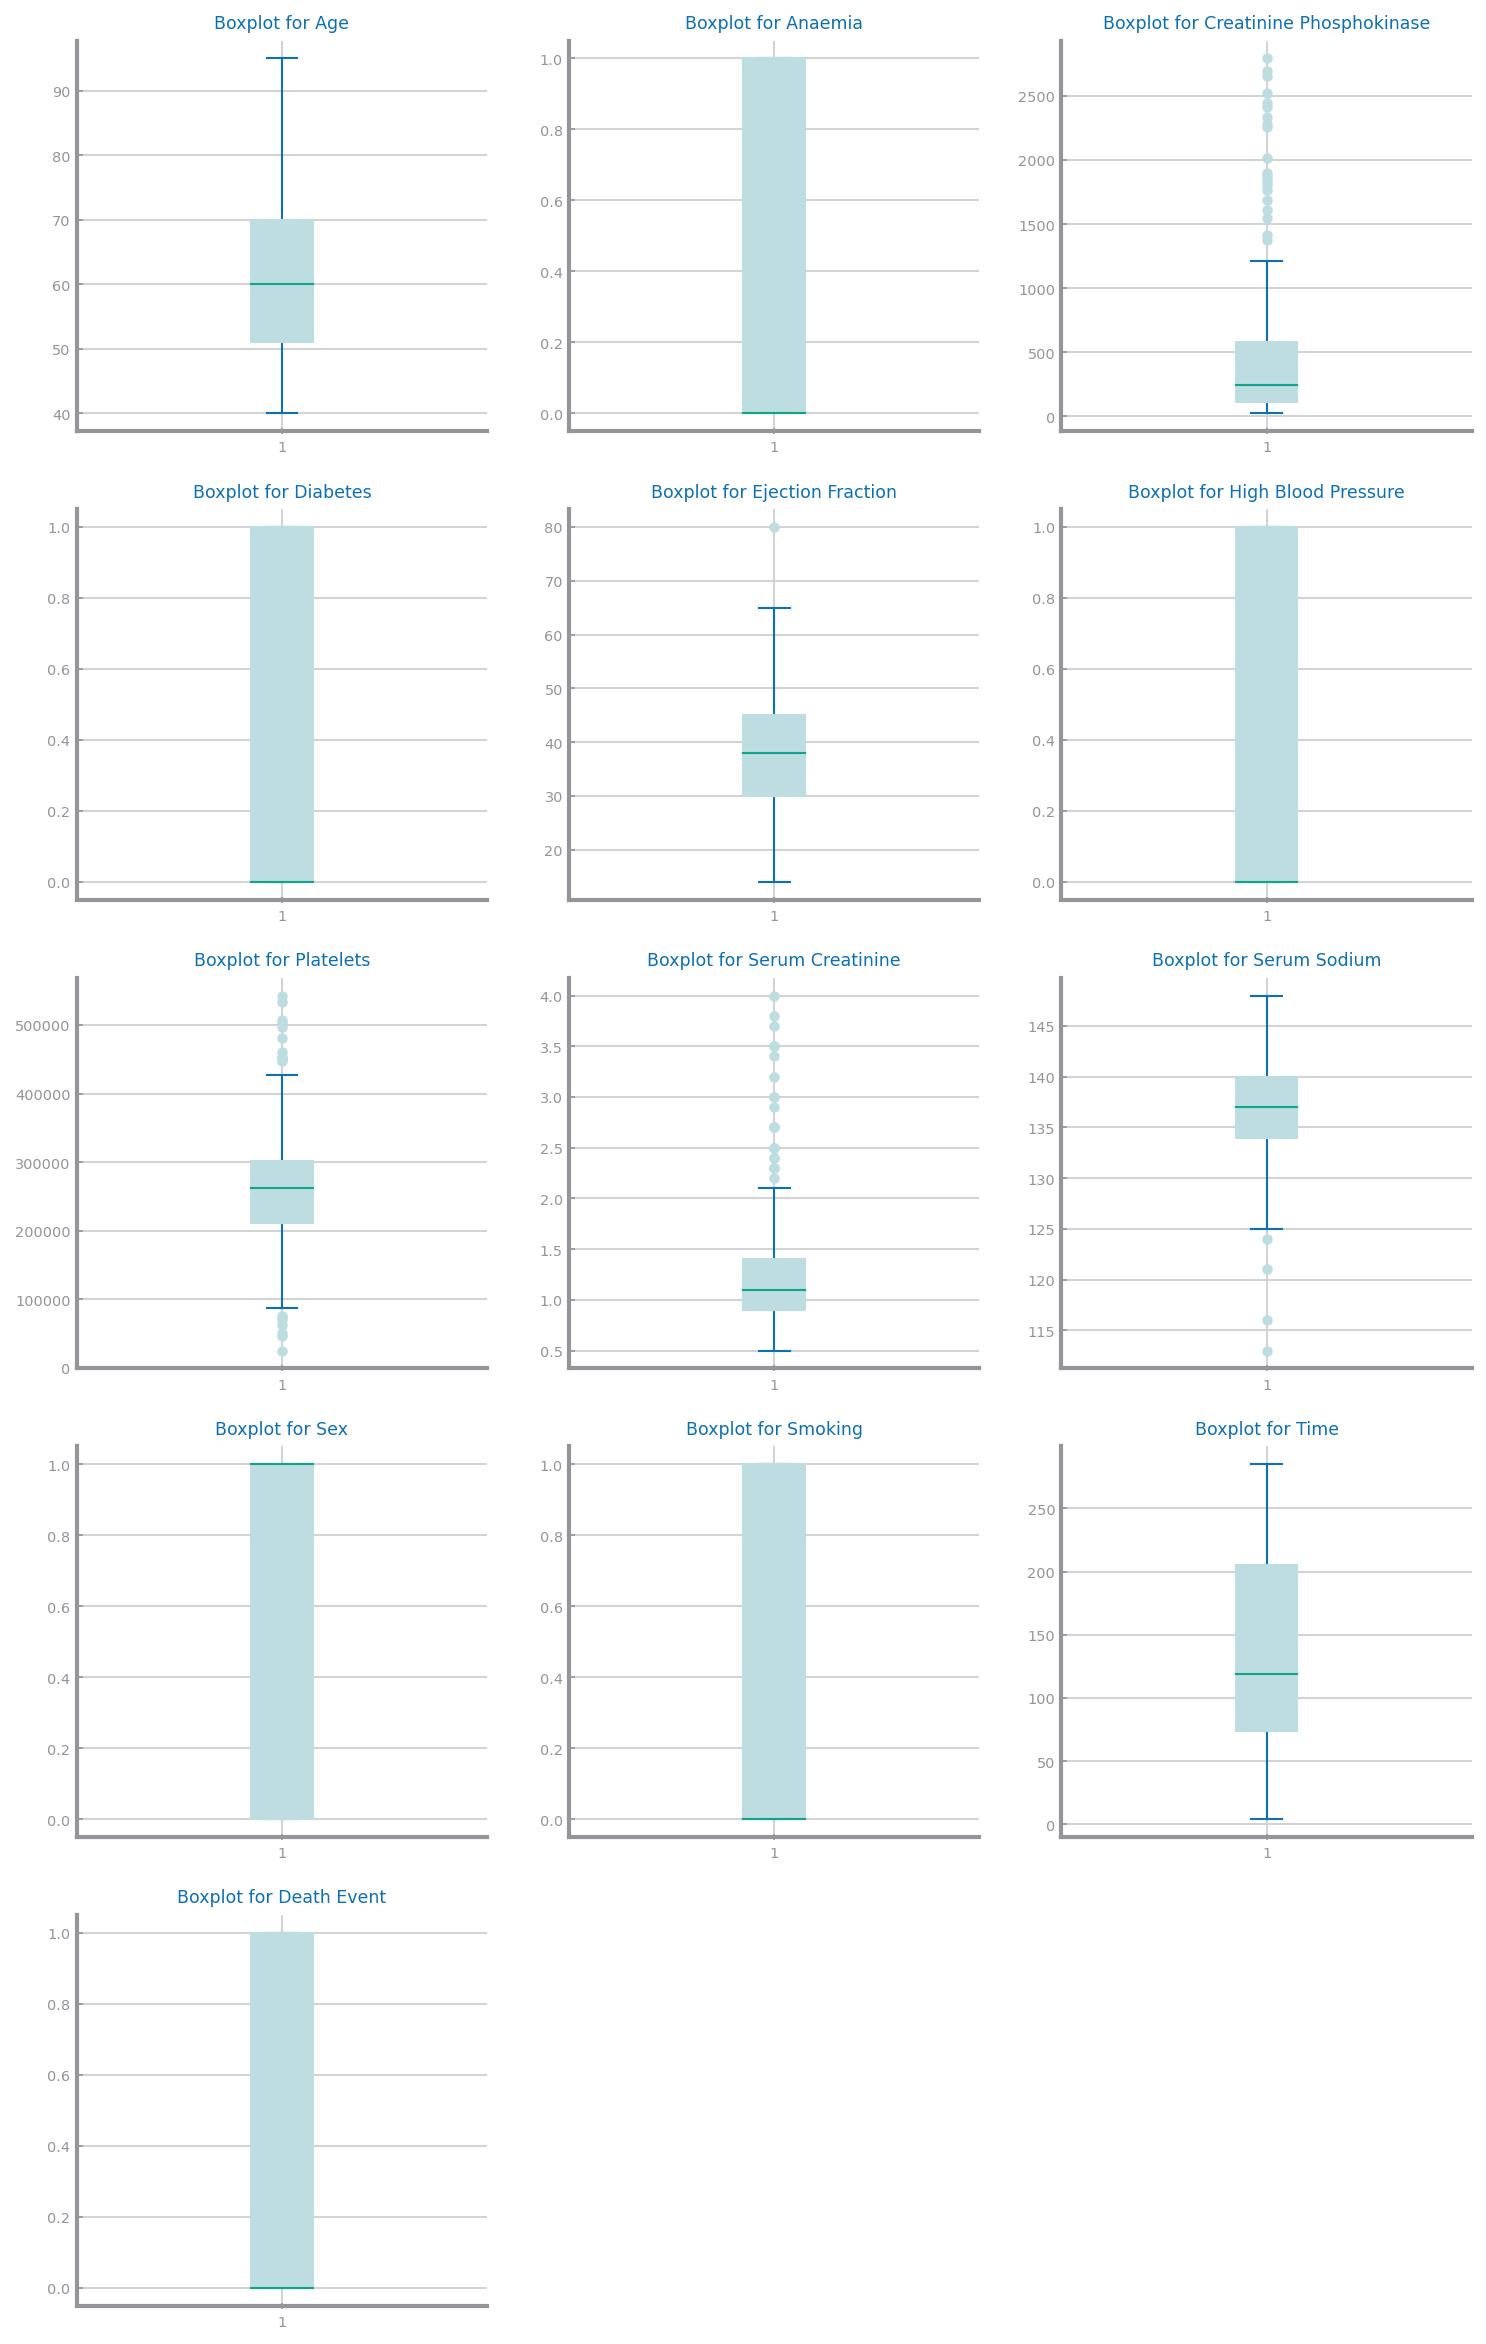

In [6]:
numeric_vars = hf_df_wo.select_dtypes(include=['float64','int64']).columns
rows, cols = ds.choose_grid(len(numeric_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(numeric_vars)):
    new_var_name = numeric_vars[n].replace("_", " ").title()
    axs[i, j].set_title(f'Boxplot for {new_var_name}')
    axs[i, j].boxplot(hf_df_wo[numeric_vars[n]].dropna().values, whis=1.5)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)

while n <= len(numeric_vars):
    axs[i, j].axis('off')
    n = n + 1
    i, j = (i + 1, 0) if n % cols == 0 else (i, j + 1)

plt.show()

## Decision Trees

### With outliers

<Figure size 600x450 with 0 Axes>

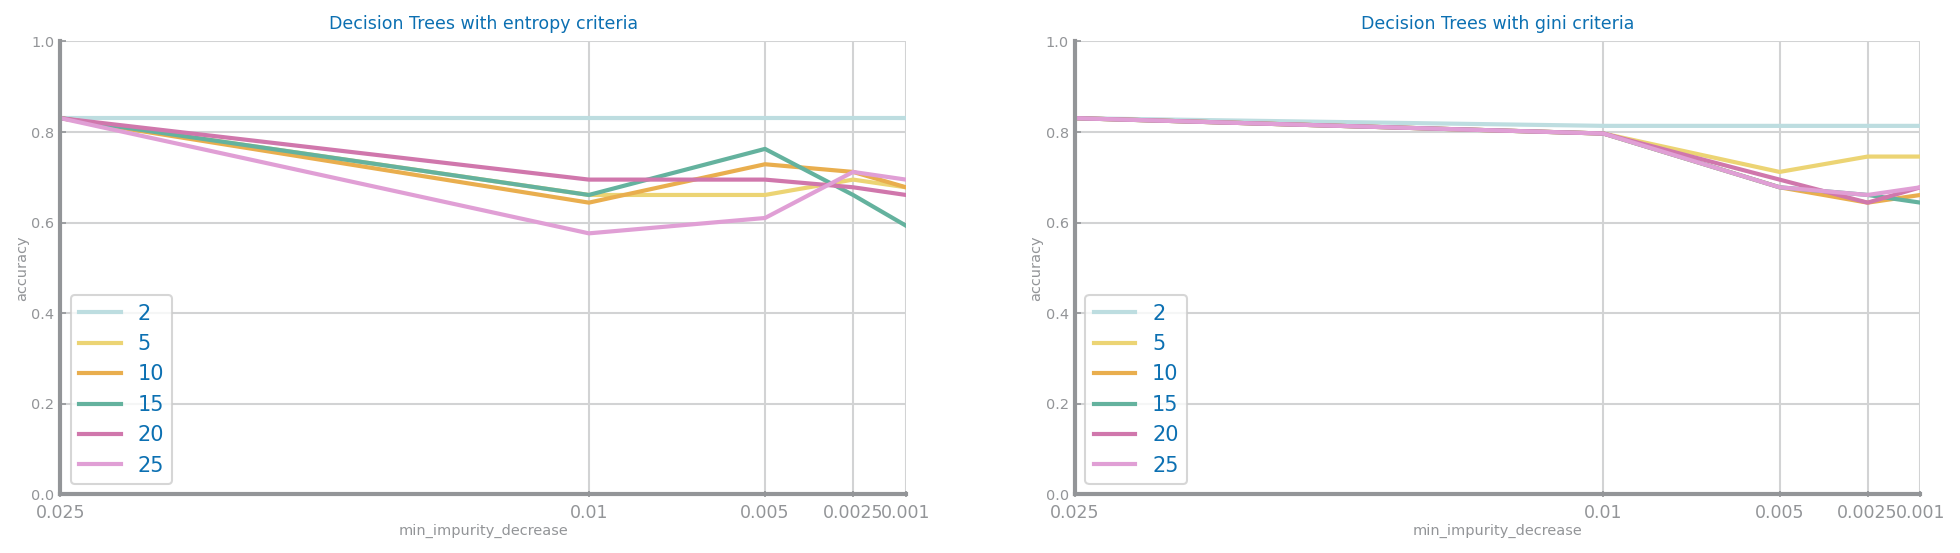

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.025 ==> accuracy=0.831


DecisionTreeClassifier(criterion='entropy', max_depth=2,
                       min_impurity_decrease=0.025)

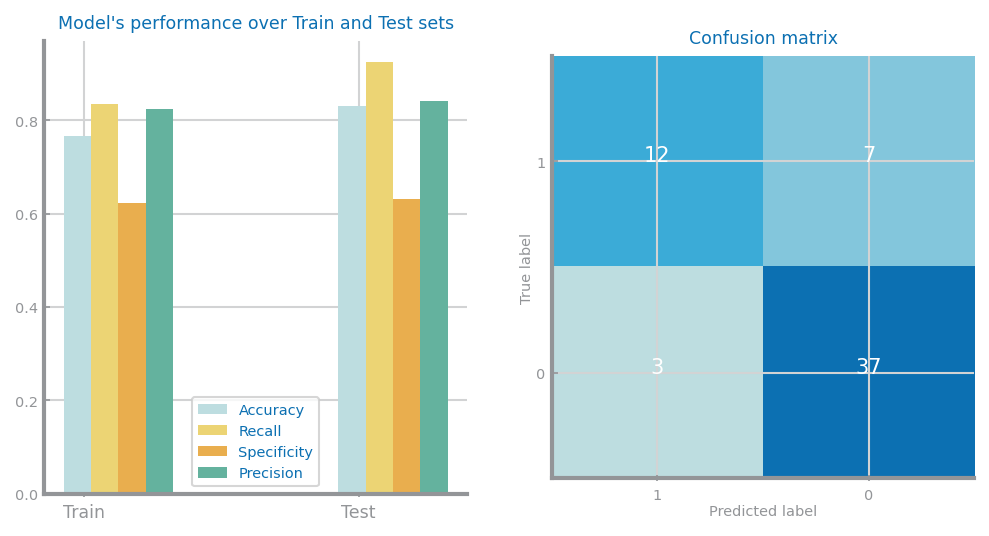

In [7]:
dtree(hf_data_raw)

### Without outliers

<Figure size 600x450 with 0 Axes>

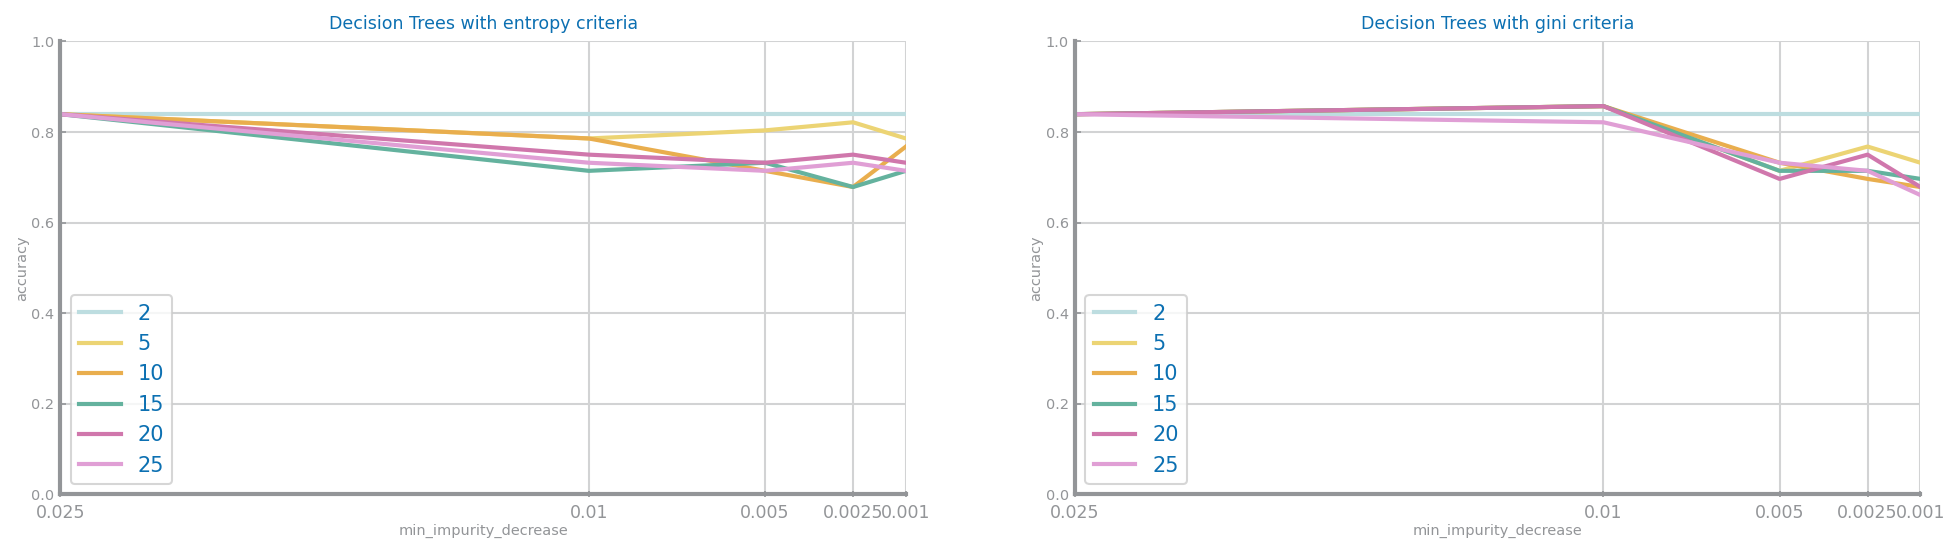

Best results achieved with gini criteria, depth=5 and min_impurity_decrease=0.010 ==> accuracy=0.857


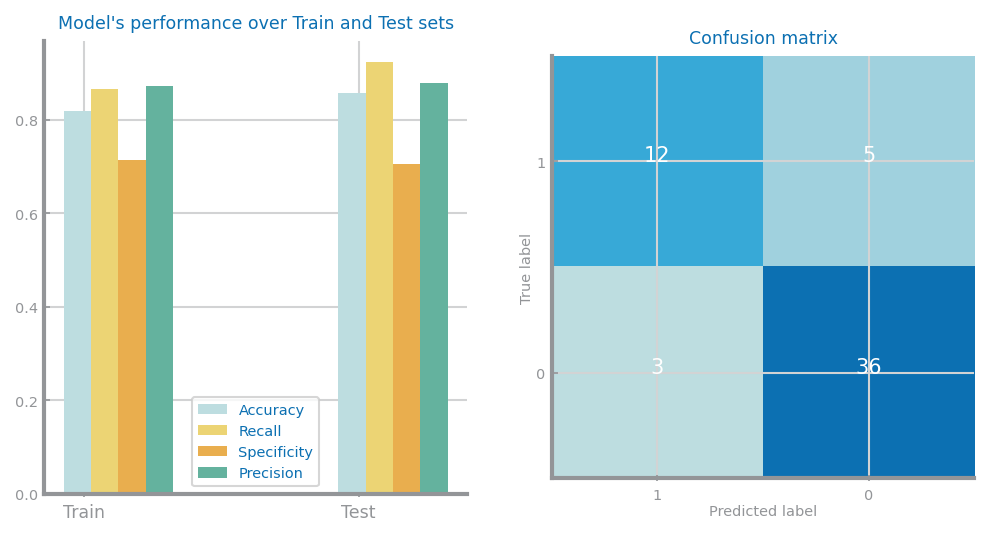

In [12]:
best_tree = dtree(hf_df_wo)

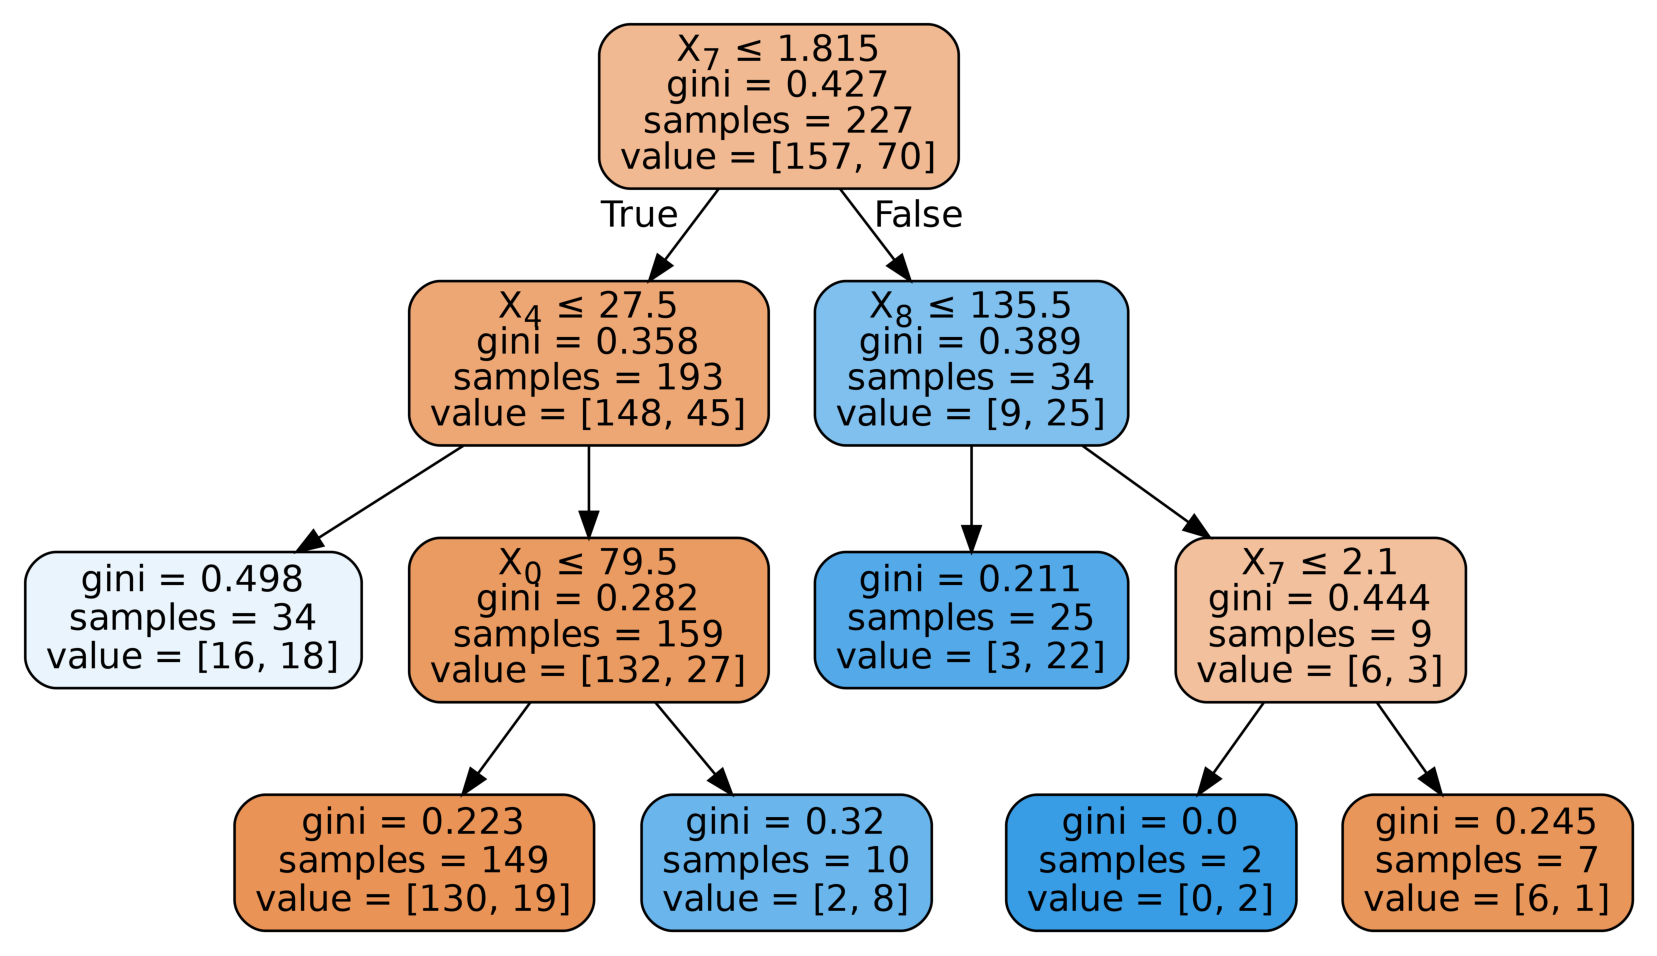

In [13]:
dtree_graph(best_tree)

### Balancing

In [9]:
hf_data_oversample = get_hf_data(filter_outliers=False, feature_selection=False, scaling="none", balancing="oversample")

<Figure size 600x450 with 0 Axes>

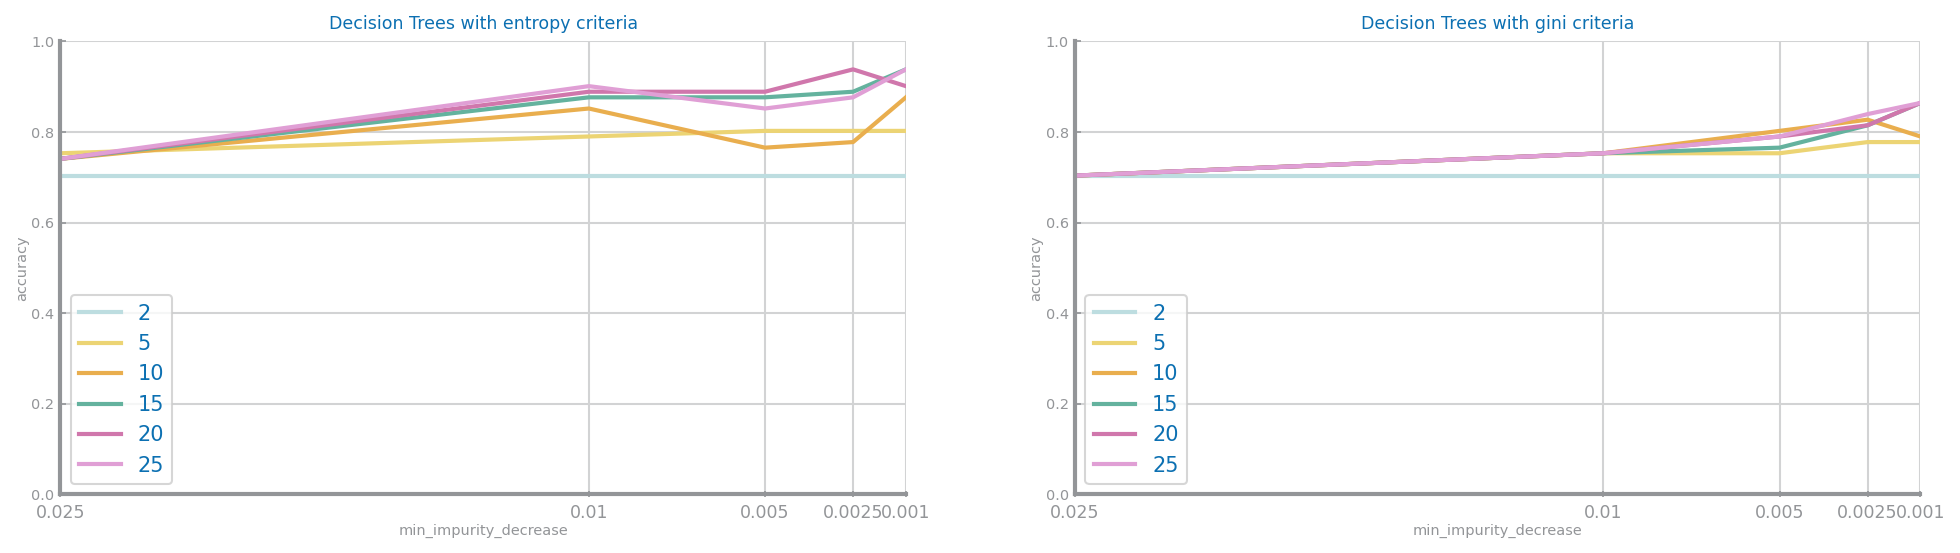

Best results achieved with entropy criteria, depth=15 and min_impurity_decrease=0.001 ==> accuracy=0.938


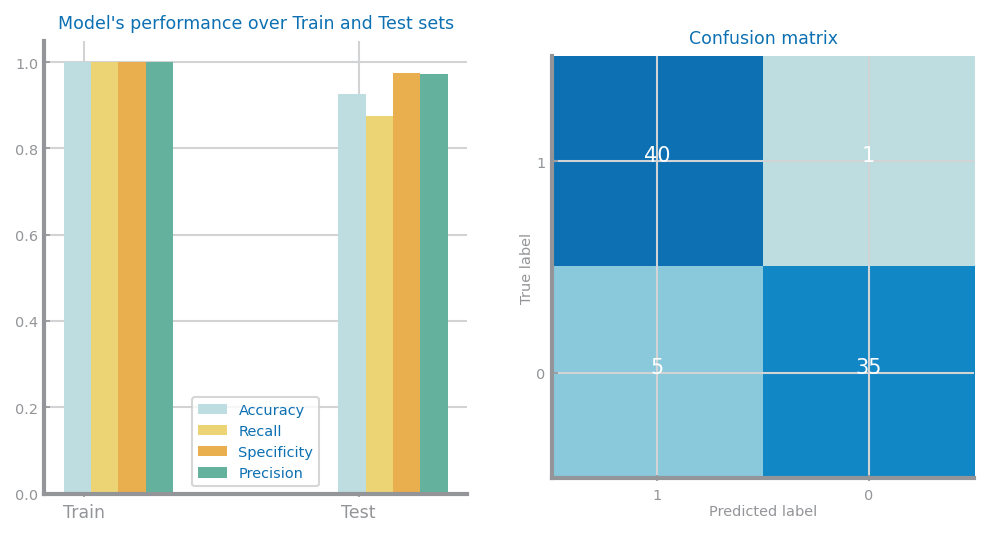

In [10]:
best_tree = dtree(hf_data_oversample)

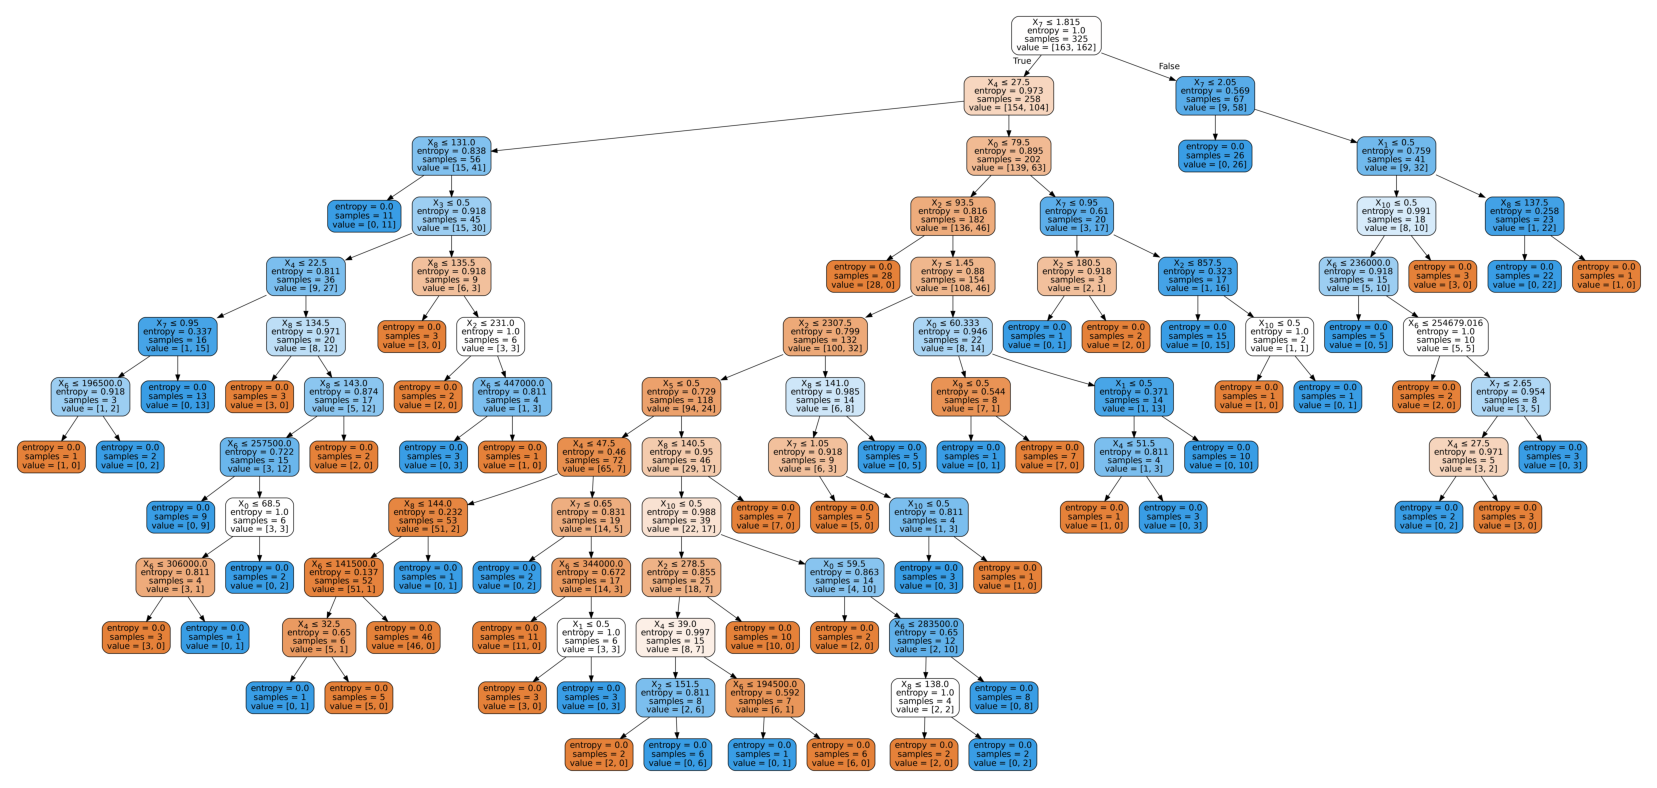

In [11]:
dtree_graph(best_tree)

## Overfitting

<Figure size 600x450 with 0 Axes>

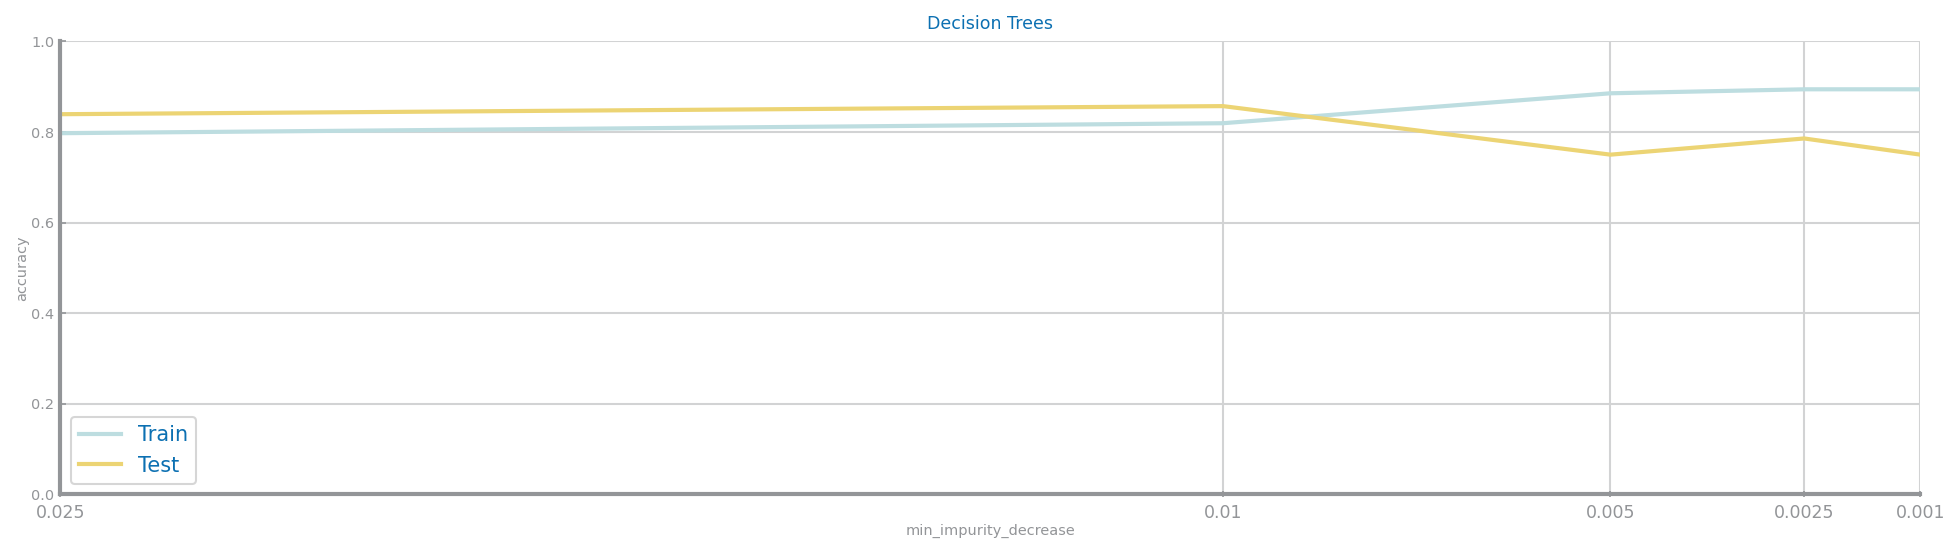

In [12]:
plt.figure()
fig, axs = plt.subplots(1, 1, figsize=(16, 4), squeeze=False)
values = {'Train':[], 'Test':[]}
for imp in min_impurity_decrease:
    tree = DecisionTreeClassifier(max_depth=best[1], criterion=best[0], min_impurity_decrease=imp)
    tree.fit(trnX, trnY)
    prdY = tree.predict(tstX)
    prdYTrain = tree.predict(trnX)
    values['Train'].append(metrics.accuracy_score(trnY, prdYTrain))
    values['Test'].append(metrics.accuracy_score(tstY, prdY))

ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, 0], title='Decision Trees',
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

# Toxicity Dataset

## Missing Values Imputation

There are no missing values :)

In [13]:
mv2 = {str(var): t_data_raw[var].isna().sum() for var in t_data_raw if t_data_raw[var].isna().sum() > 0}
print(len(mv2))

0


## Outliers (Un)Imputation

There are only 0 and 1 values, so there are no outliers.

## Decision Trees

<Figure size 600x450 with 0 Axes>

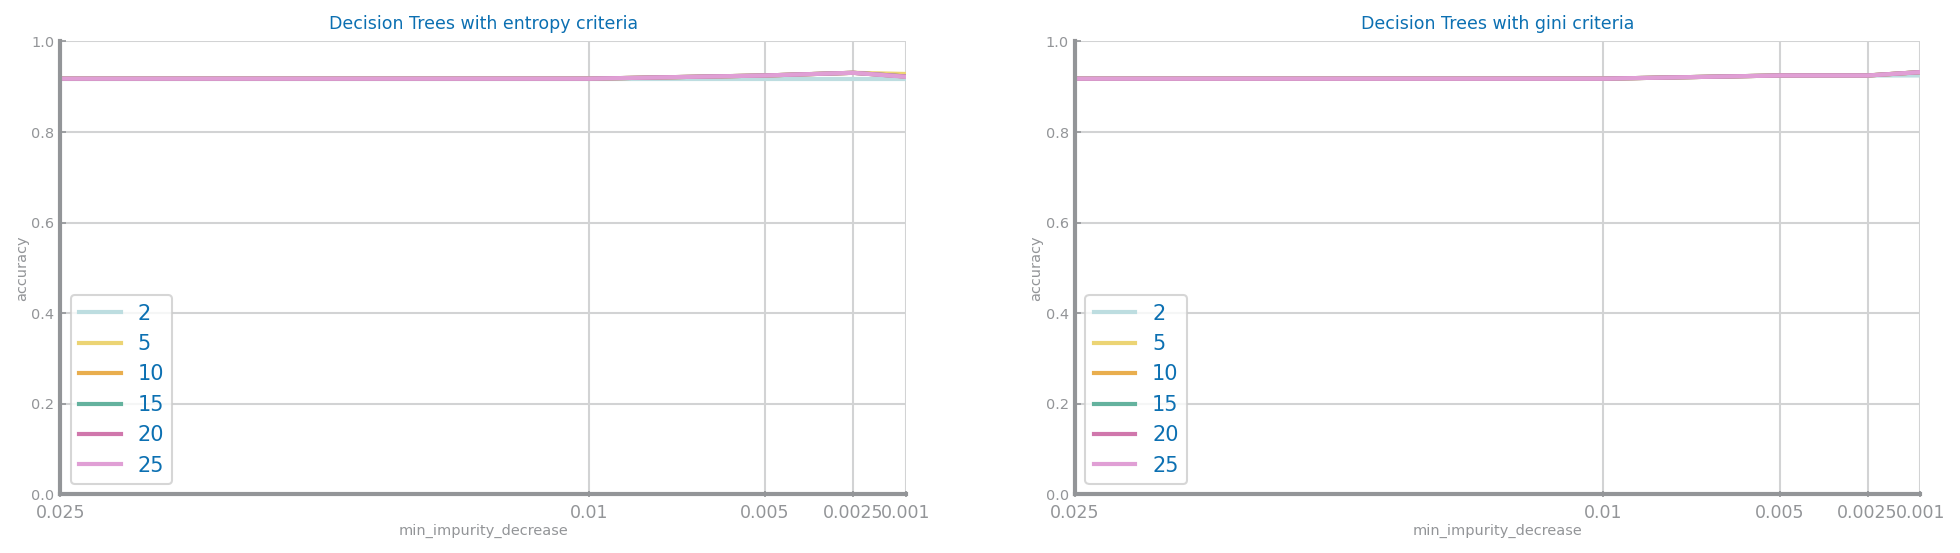

Best results achieved with gini criteria, depth=5 and min_impurity_decrease=0.0010 ==> accuracy=0.9322


In [14]:
t_df = t_data.copy()
y: np.ndarray = t_df.pop('toxic').values
X: np.ndarray = t_df.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
#             print(f, d, imp, yvalues[-1])
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.4f ==> accuracy=%1.4f'%(best[0], best[1], best[2], last_best))

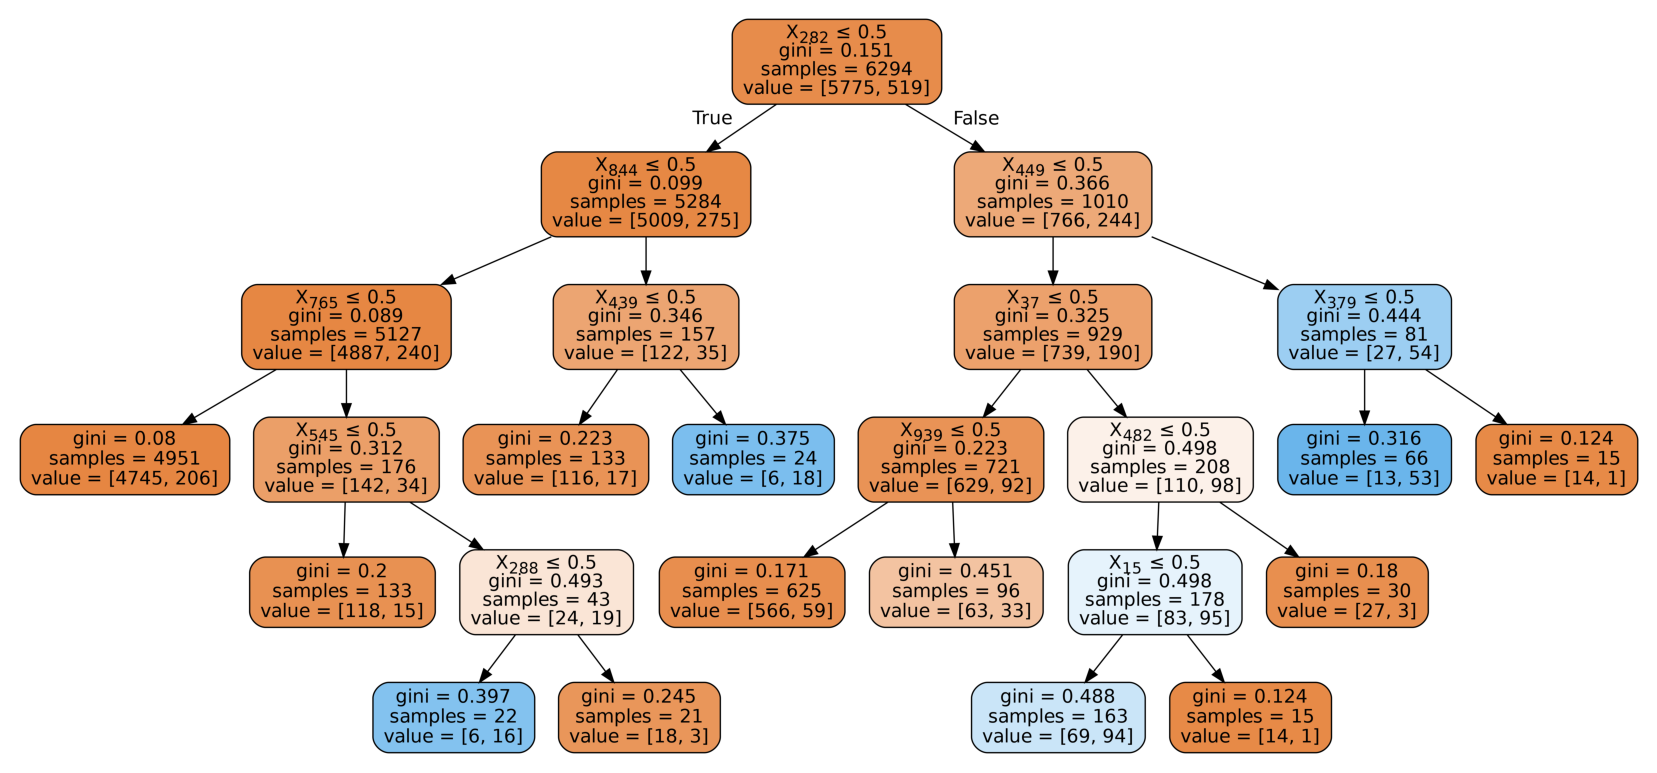

In [15]:
from sklearn.tree import export_graphviz

dot_data = export_graphviz(best_tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=600'])

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('dtree.png'))
plt.axis('off')
plt.show()

## Overfitting

<Figure size 600x450 with 0 Axes>

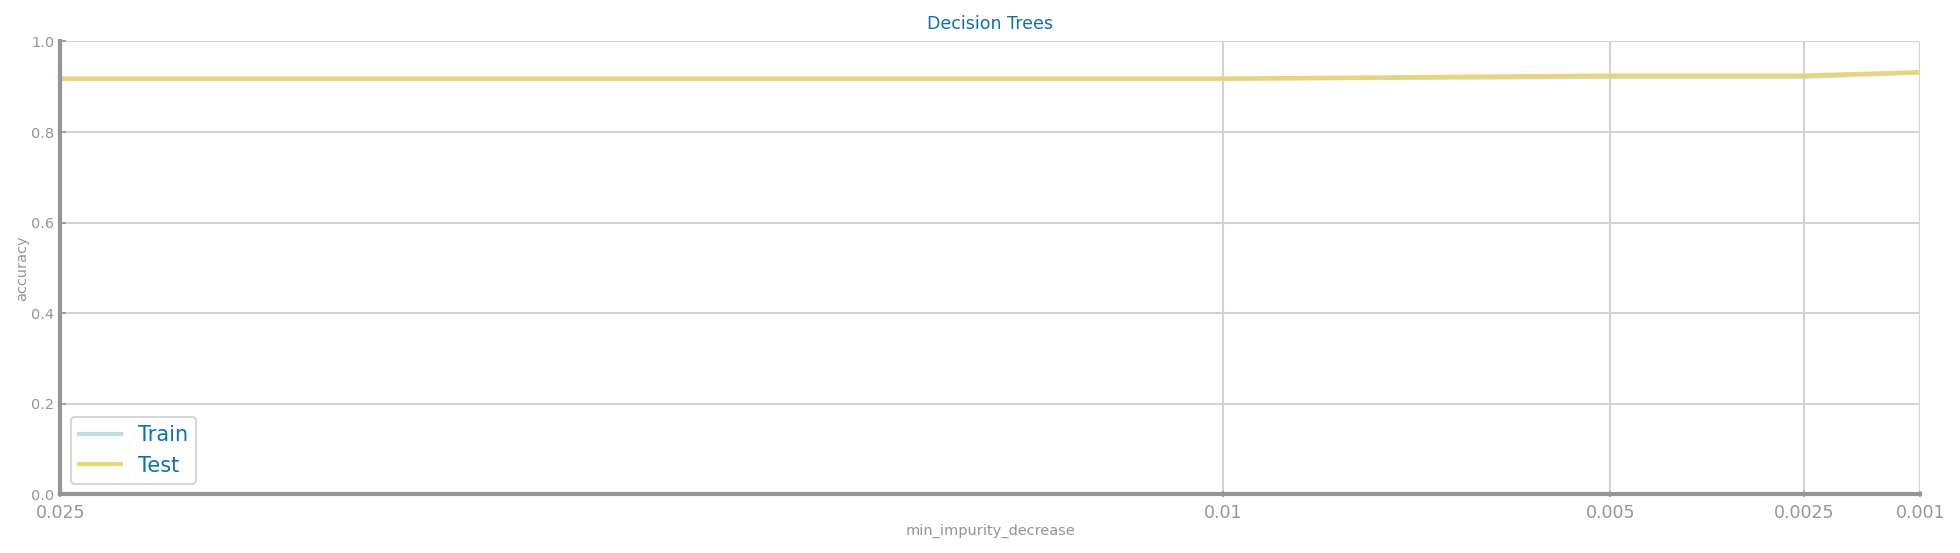

In [16]:
plt.figure()
fig, axs = plt.subplots(1, 1, figsize=(16, 4), squeeze=False)
values = {'Train':[], 'Test':[]}
for imp in min_impurity_decrease:
    tree = DecisionTreeClassifier(max_depth=best[1], criterion=best[0], min_impurity_decrease=imp)
    tree.fit(trnX, trnY)
    prdY = tree.predict(tstX)
    prdYTrain = tree.predict(trnX)
    values['Train'].append(metrics.accuracy_score(trnY, prdYTrain))
    values['Test'].append(metrics.accuracy_score(tstY, prdY))

ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, 0], title='Decision Trees',
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)